In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
import cv2

In [3]:
metadata_path = os.path.join('pfe/HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)

In [4]:
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [5]:
metadata.shape

(10015, 7)

**Check the distribution of the classes**

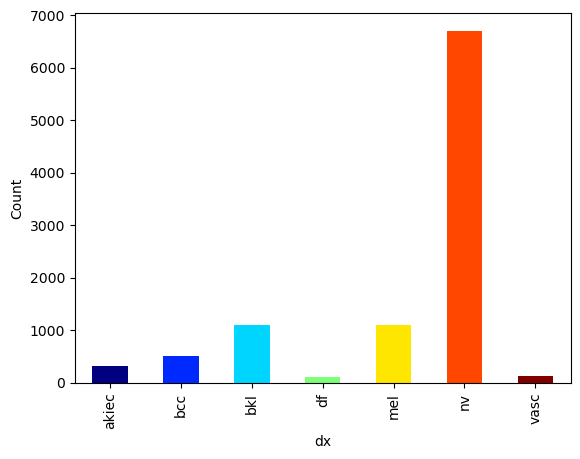

In [6]:
count = metadata.dx.value_counts().sort_index()

unique_vals = count.index
colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

count.plot(kind='bar', color=colors)

plt.ylabel('Count')
plt.show()

# Clean the metadata

**Missing data:**

Fill the missing data valeues with the mean of their category, since the category is a float number.

In [7]:
def check_for_missing_data(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    return summary

In [8]:
check_for_missing_data(metadata)

Name   dtypes  Missing
0     lesion_id   object        0
1      image_id   object        0
2            dx   object        0
3       dx_type   object        0
4           age  float64       57
5           sex   object        0
6  localization   object        0

In [9]:
metadata['age'].fillna((metadata['age'].mean()), inplace=True)

In [10]:
def convert_float_to_int(df, column_name):
    if df[column_name].dtype == 'float64':
        df[column_name] = df[column_name].astype(int)
    return df

In [11]:
metadata = convert_float_to_int(metadata,'age')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           10015 non-null  int32 
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
dtypes: int32(1), object(6)
memory usage: 508.7+ KB


**Remove the duplicates if there are any**

In [12]:
def check_for_duplicate_rows(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum()
    return print("Number of Samples:" ,size[0],"\nDuplicated Entries: " ,sum_duplicates,"\nNull Entries:","\n",sum_null)

In [13]:
check_for_duplicate_rows(metadata)

Number of Samples: 10015 
Duplicated Entries:  0 
Null Entries: 
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [14]:
lesion_id_cnt = metadata['lesion_id'].value_counts()
def check_duplicates_lesions(id):
    if lesion_id_cnt[id] > 1:
        return True
    else:
        return False

metadata['dup_les'] = metadata['lesion_id'].map(check_duplicates_lesions)

In [15]:
metadata['dup_les'].value_counts()

dup_les
False    5514
True     4501
Name: count, dtype: int64

In [16]:
metadata = metadata[metadata.dup_les == False]
metadata.shape

(5514, 8)

In [17]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = 'HAM10000_images_part_1.zip'  # Replace with your zip file path
extraction_dir = 'HAM10000_images_part_1'  # Replace with the directory where you want to extract

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f'Extracted all files to {extraction_dir}')


Extracted all files to HAM10000_images_part_1


In [18]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = 'HAM10000_images_part_2.zip'  # Replace with your zip file path
extraction_dir = 'HAM10000_images_part_2'  # Replace with the directory where you want to extract

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f'Extracted all files to {extraction_dir}')


Extracted all files to HAM10000_images_part_2


# Load the images paths

Create 2 paths from drive. The images are separeted in these paths, so if they do not exist in path 1 they probably exist in path 2. Scanning all the rows using the "dx" and the "image_id" columns we can add the image path in a separete column in the dataframe.

In [22]:
base1_path = os.path.join('HAM10000_images_part_1')
base2_path = os.path.join('HAM10000_images_part_2')

image_paths = []

for index, row in metadata.iterrows():
  image_id = row['image_id']
  class_name = row['dx']

  part1_path = os.path.join(base1_path)
  part2_path = os.path.join(base2_path)

  image_path_1 = os.path.join(part1_path, f'{image_id}.jpg')
  image_path_2 = os.path.join(part2_path, f'{image_id}.jpg')

  if os.path.exists(image_path_1):
    image_paths.append(image_path_1)
  elif os.path.exists(image_path_2):
    image_paths.append(image_path_2)
  else: print(f'None of the paths {image_path_1} and {image_path_2} exists in google drive.')

metadata['image_path'] = image_paths

In [23]:
metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                 image_path  
10  HAM10000_images_part_1\ISIC_0025276.jpg  
15  HAM10000_images_part_2\ISIC_0031326.jpg  
20  HAM10000_images_part_2\ISIC_0032343.jpg  
33  HAM10000_images_part_1\ISIC_0024981.jpg  
34  HAM10000_images_part_1\ISIC_0027815.jpg

In [24]:
metadata.shape

(5514, 9)

# Exploration

<Axes: ylabel='count'>

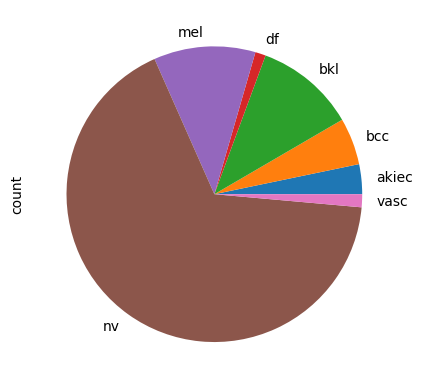

In [25]:
count.plot(kind='pie')

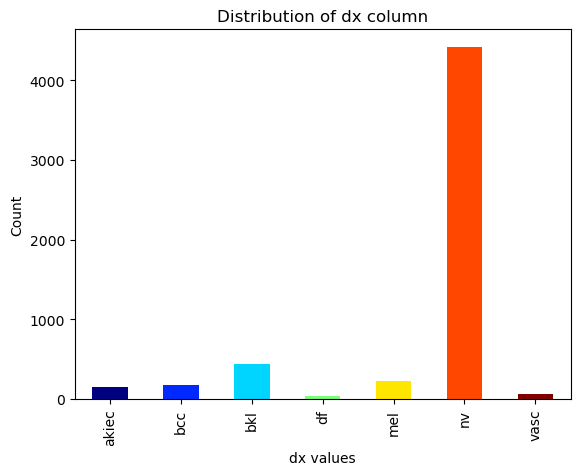

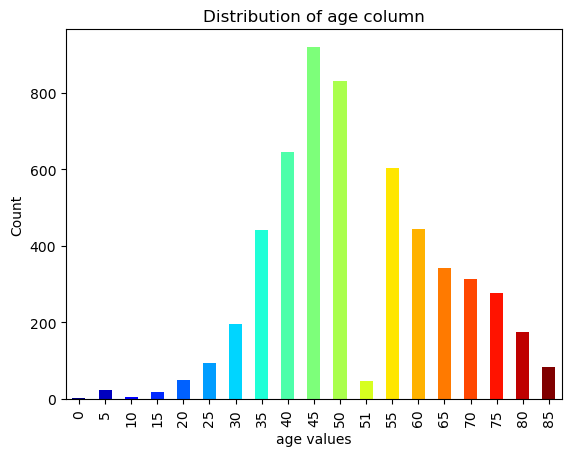

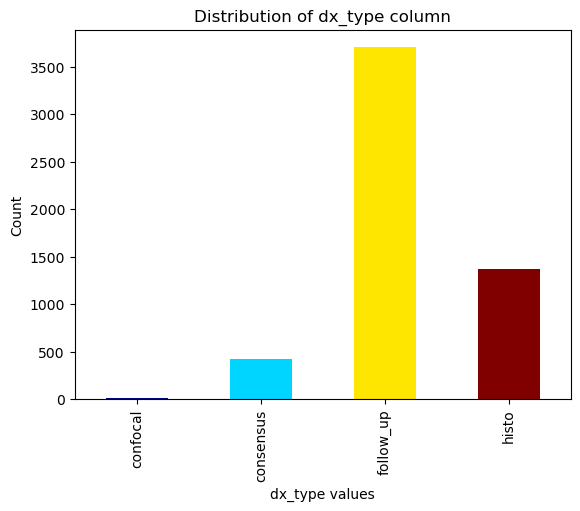

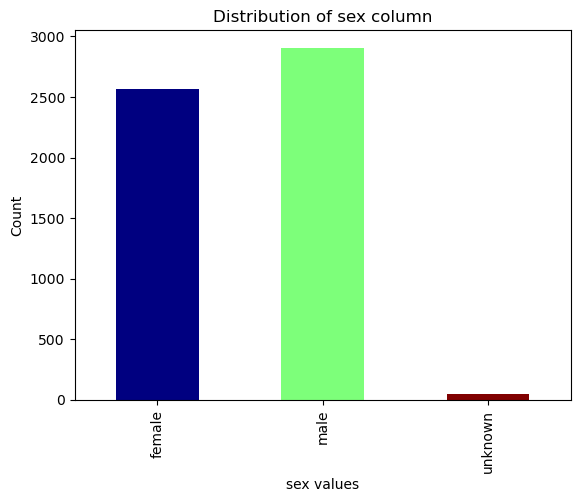

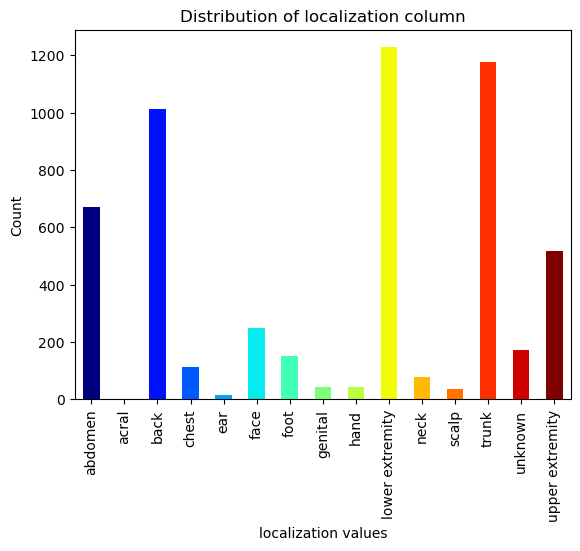

In [26]:
columns_exp = ['dx','age','dx_type', 'sex', 'localization']

for column in columns_exp:
  count = metadata[column].value_counts().sort_index()

  unique_vals = count.index
  colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

  count.plot(kind='bar', color=colors)

  plt.xlabel(f'{column} values')
  plt.ylabel('Count')
  plt.title(f'Distribution of {column} column')
  plt.show()

In [27]:
metadata.loc[metadata['sex']=='unknown'].shape

(45, 9)

In [28]:
metadata.loc[metadata['localization']=='unknown'].shape

(173, 9)

AttributeError: 'numpy.int32' object has no attribute 'startswith'

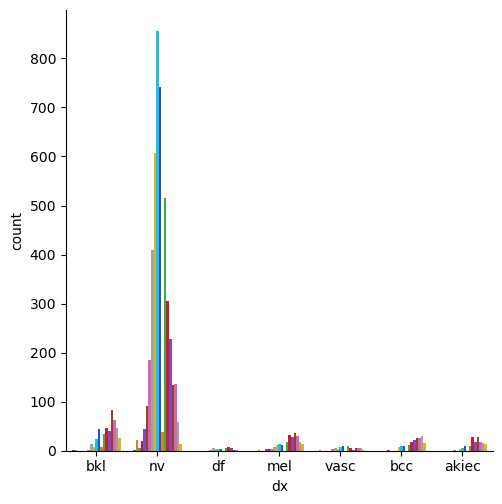

In [29]:
#Skin Cancer by age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Age')

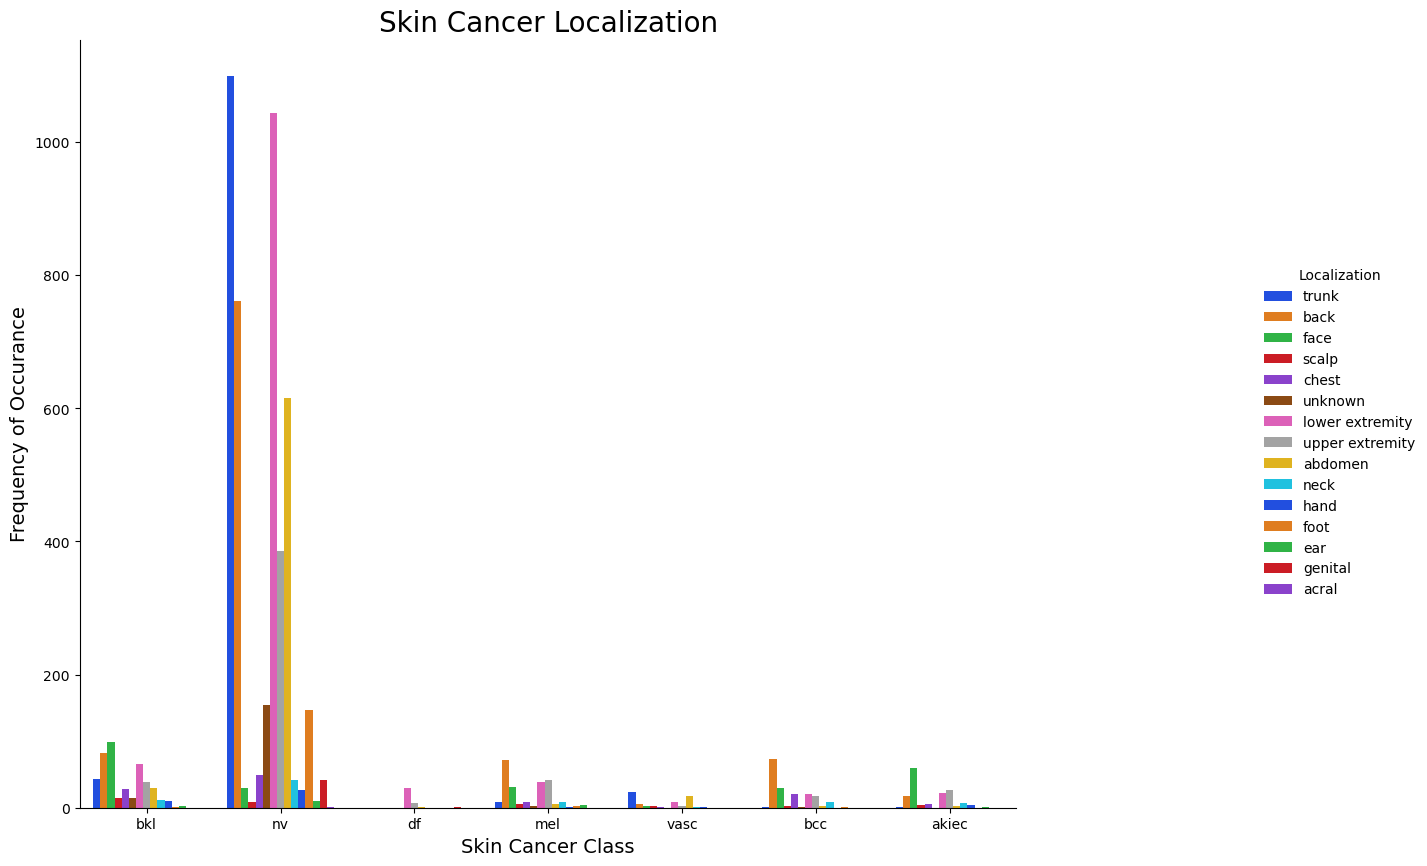

In [30]:
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

In [31]:
metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                 image_path  
10  HAM10000_images_part_1\ISIC_0025276.jpg  
15  HAM10000_images_part_2\ISIC_0031326.jpg  
20  HAM10000_images_part_2\ISIC_0032343.jpg  
33  HAM10000_images_part_1\ISIC_0024981.jpg  
34  HAM10000_images_part_1\ISIC_0027815.jpg

**Plot images from each class and their color distributions**

In [32]:
def pltImg(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {labels[i]}\nMean intensity: {np.mean(image):.1f}")

    plt.tight_layout()
    plt.show()


def pltHist(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array
    colors = ["red", "green", "blue"]

    for i, image in enumerate(images):
        image_array = np.array(image)

        # Plotting all channels with colors
        for channel in range(3):
            hist, bin_edges = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
            axes[i].plot(bin_edges[:-1], hist, color=colors[channel])

        axes[i].set_title(f"Class: {labels[i]}")

    plt.tight_layout()
    plt.show()


In [33]:
def randImg(df, label, seed, sample_size):
    # Filter dataframe for specific label/class
    df_class = df[df['dx'] == label]

    # Randomly sample images from this class
    random.seed(seed)
    sample_df = df_class.sample(n=sample_size)

    images = []
    labels = []
    for index, row in sample_df.iterrows():
        image_path = row['image_path']
        if os.path.exists(image_path):
            image = Image.open(image_path)
            images.append(image)
            labels.append(label)
        else:
            print(f"Image not found: {image_path}")

    return images, labels


--- Showcasing examples for class: bkl ---



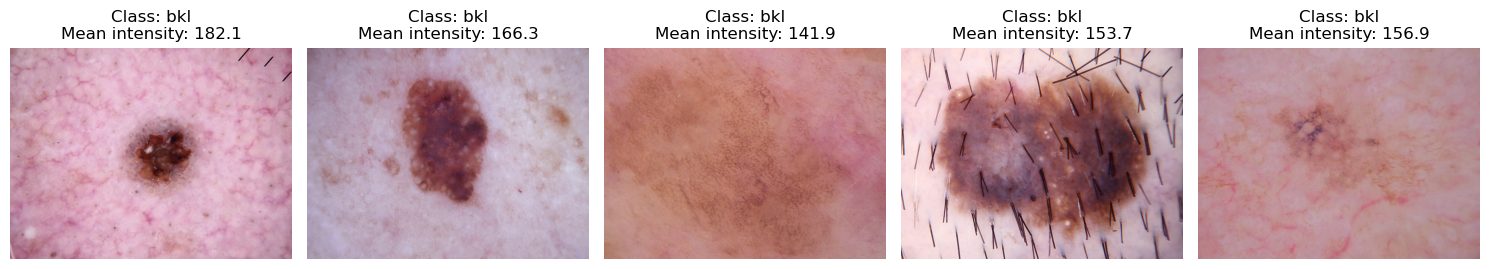

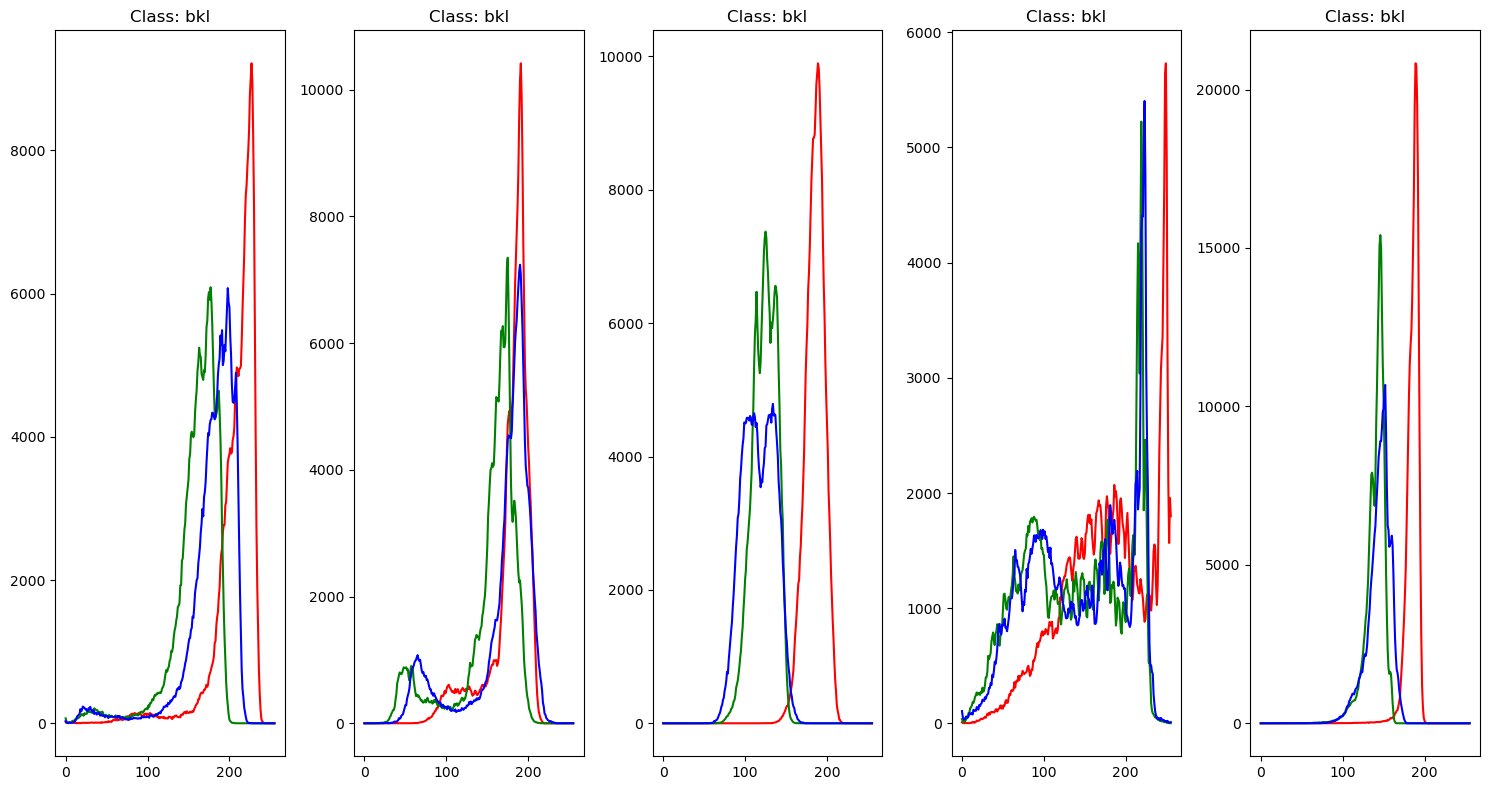


--- Showcasing examples for class: nv ---



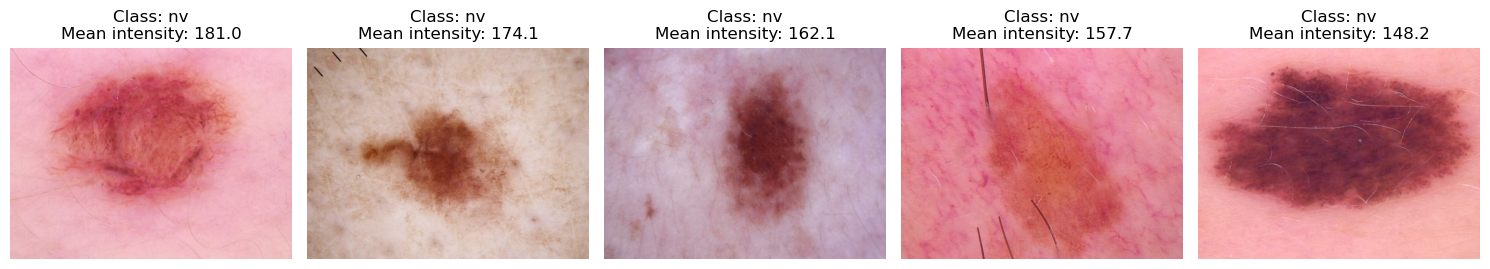

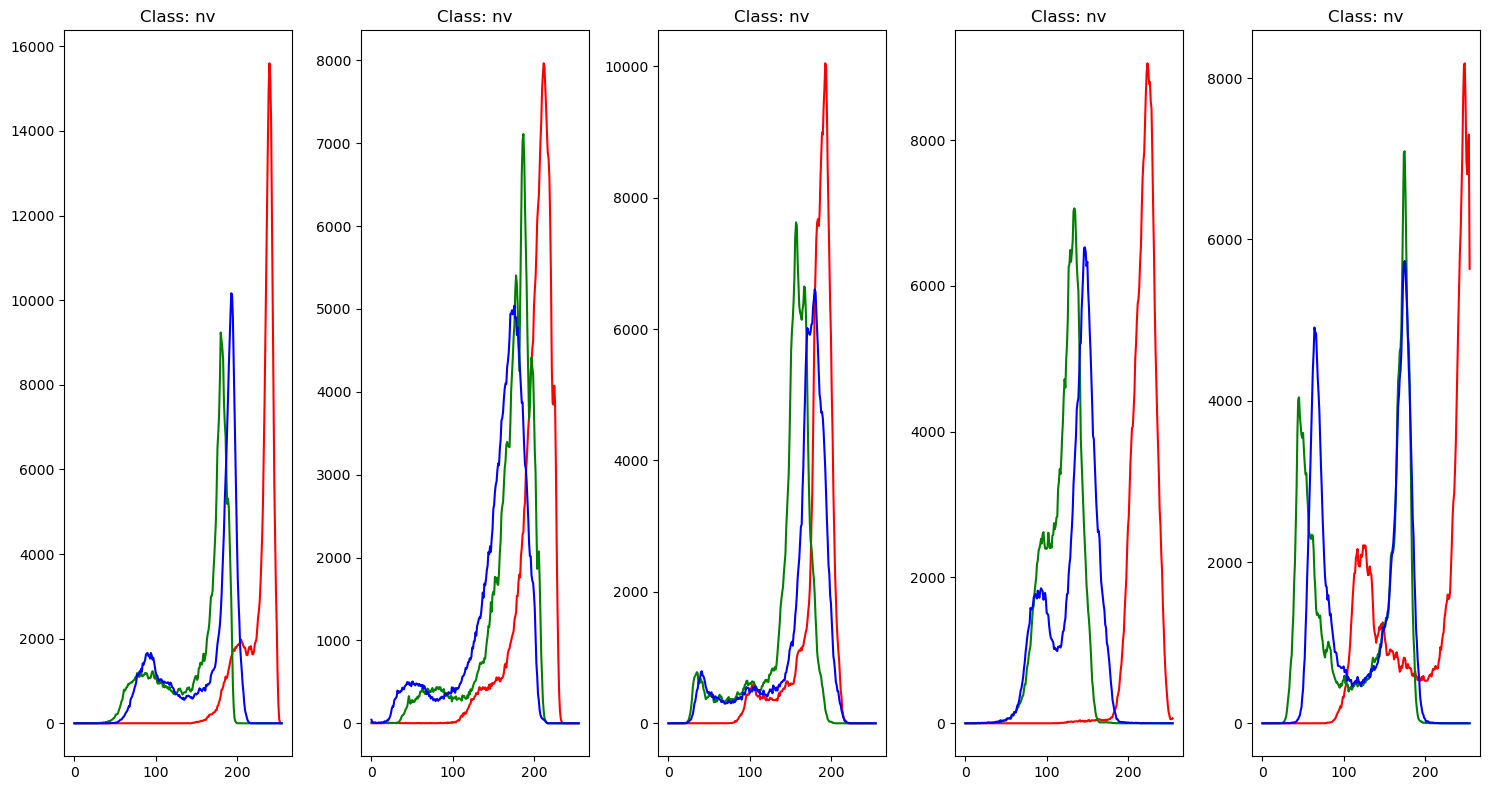


--- Showcasing examples for class: df ---



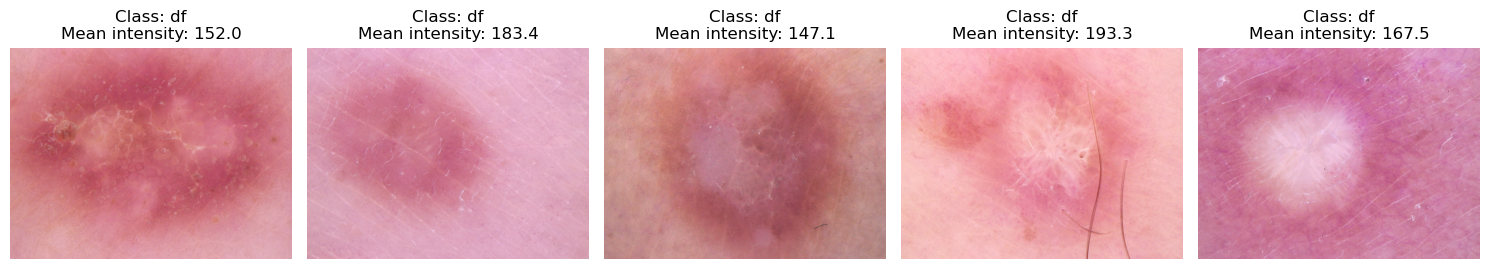

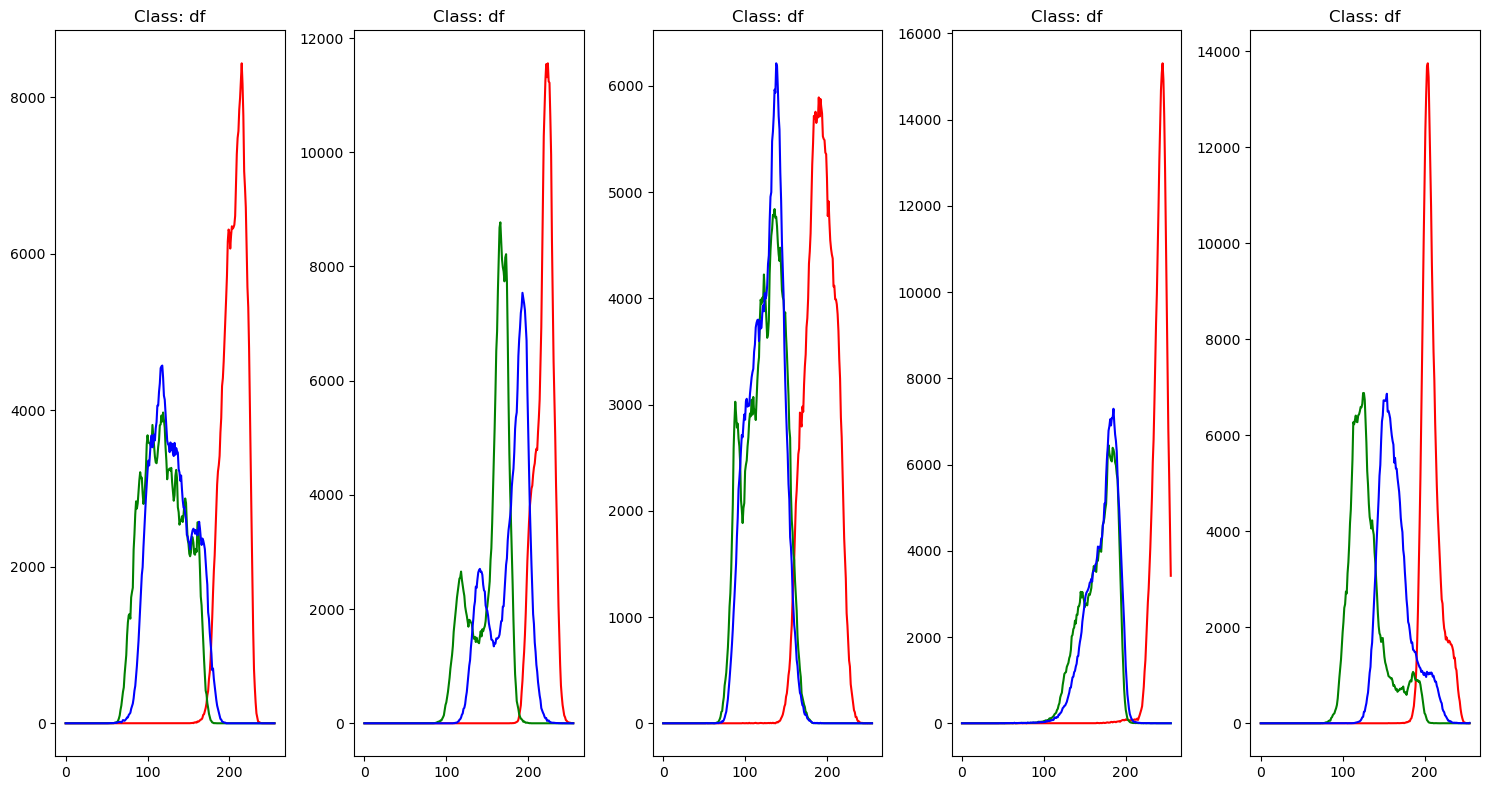


--- Showcasing examples for class: mel ---



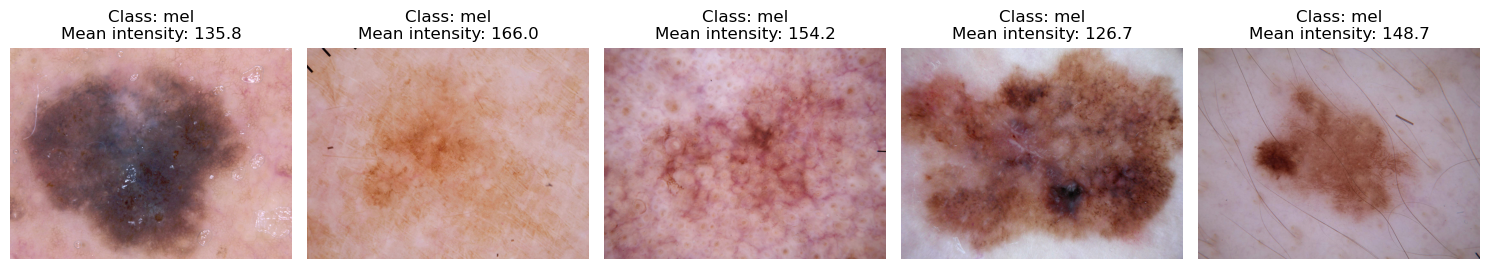

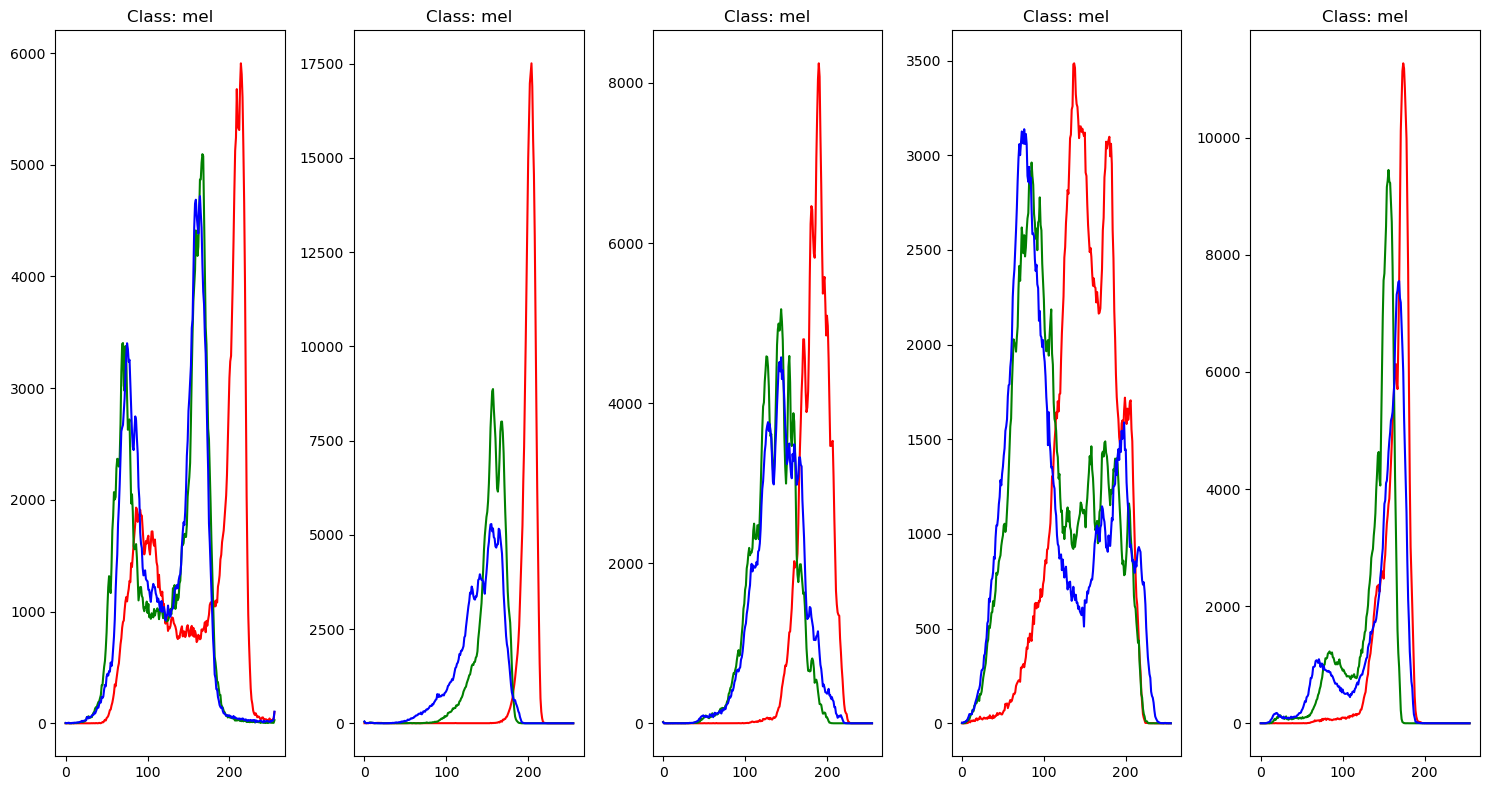


--- Showcasing examples for class: vasc ---



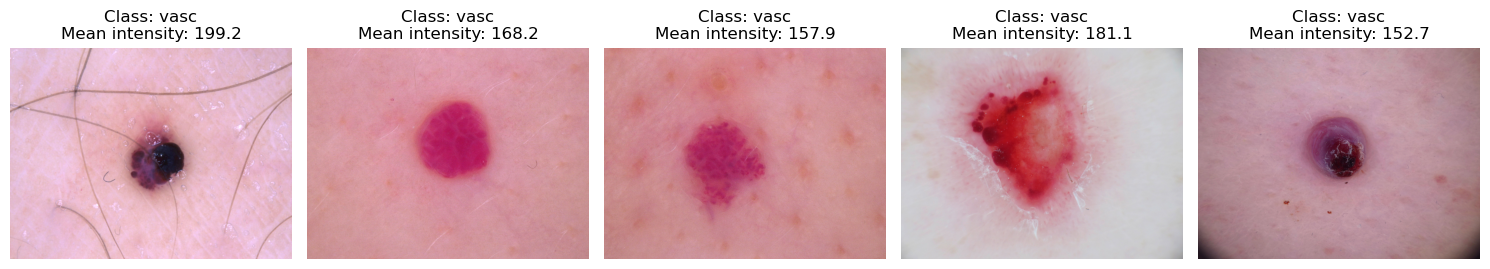

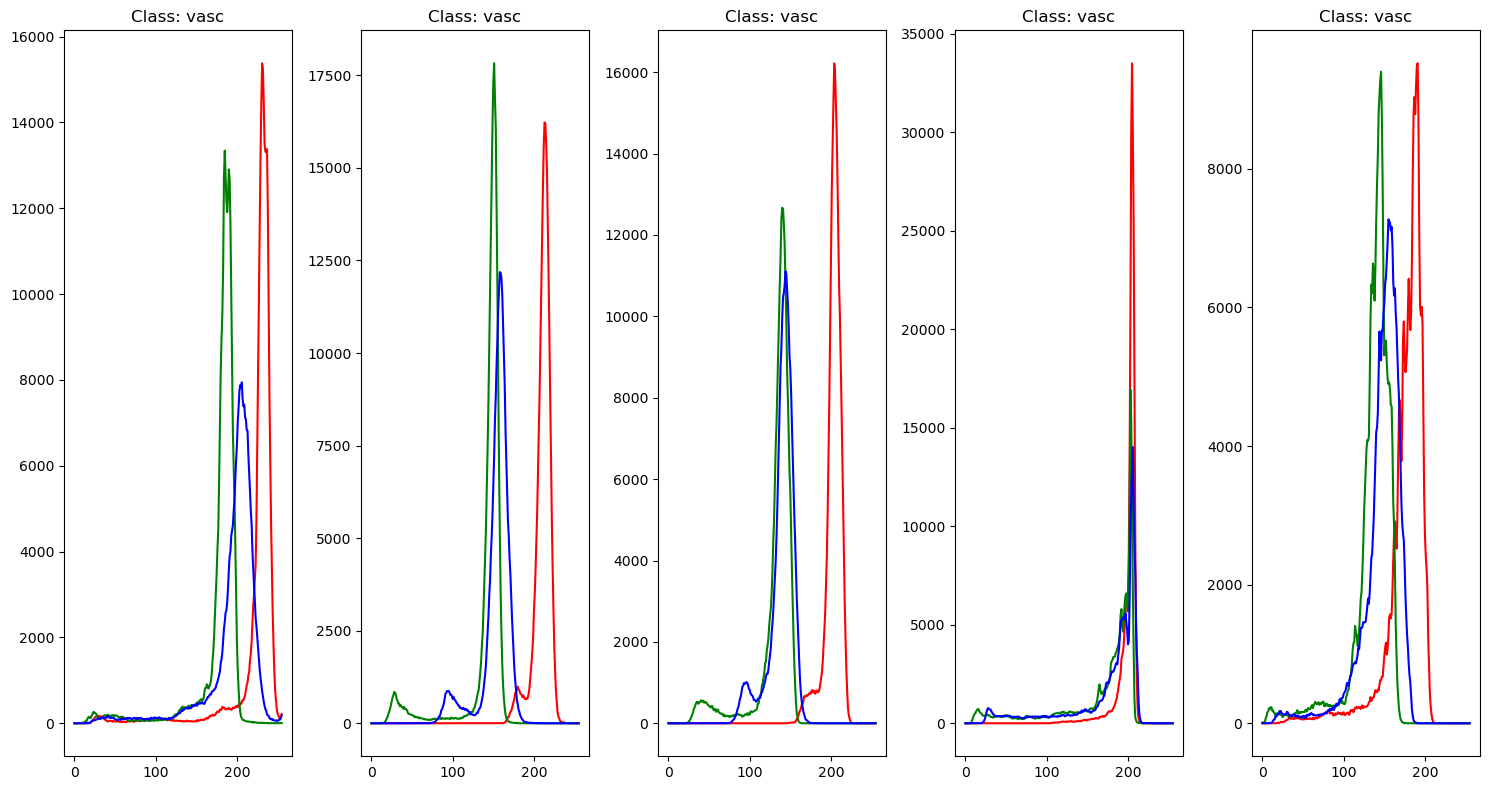


--- Showcasing examples for class: bcc ---



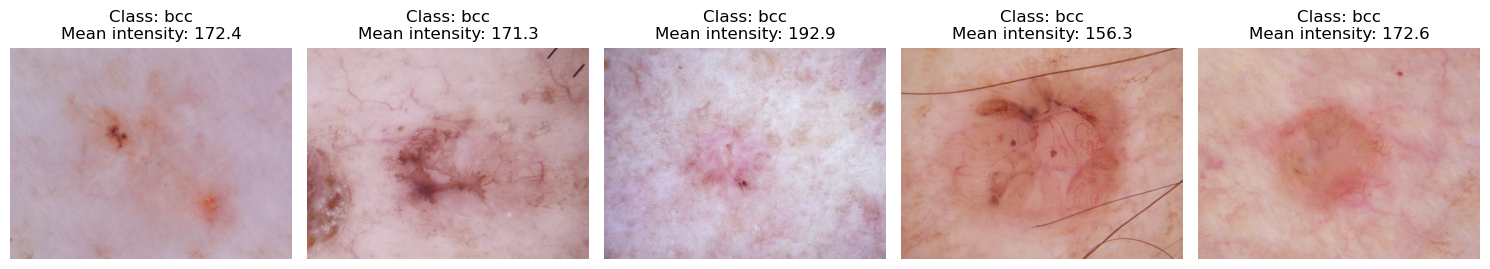

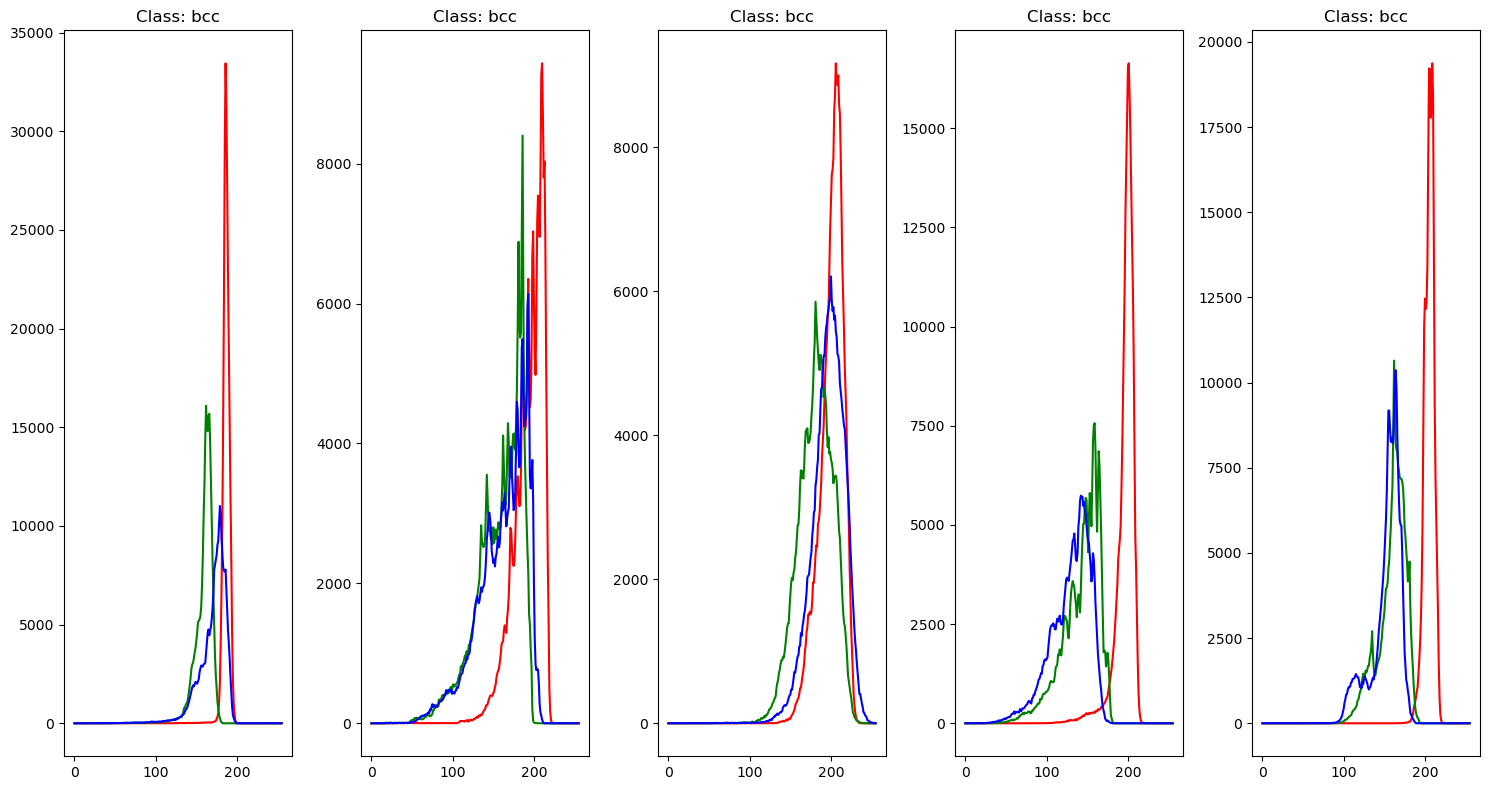


--- Showcasing examples for class: akiec ---



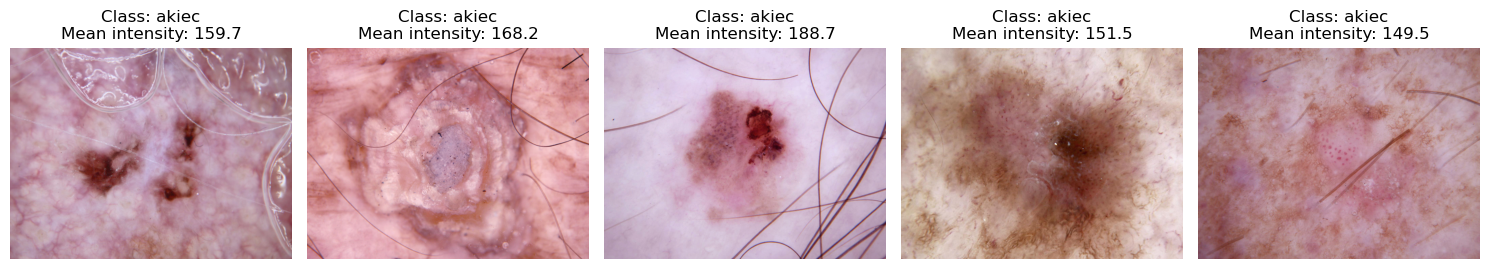

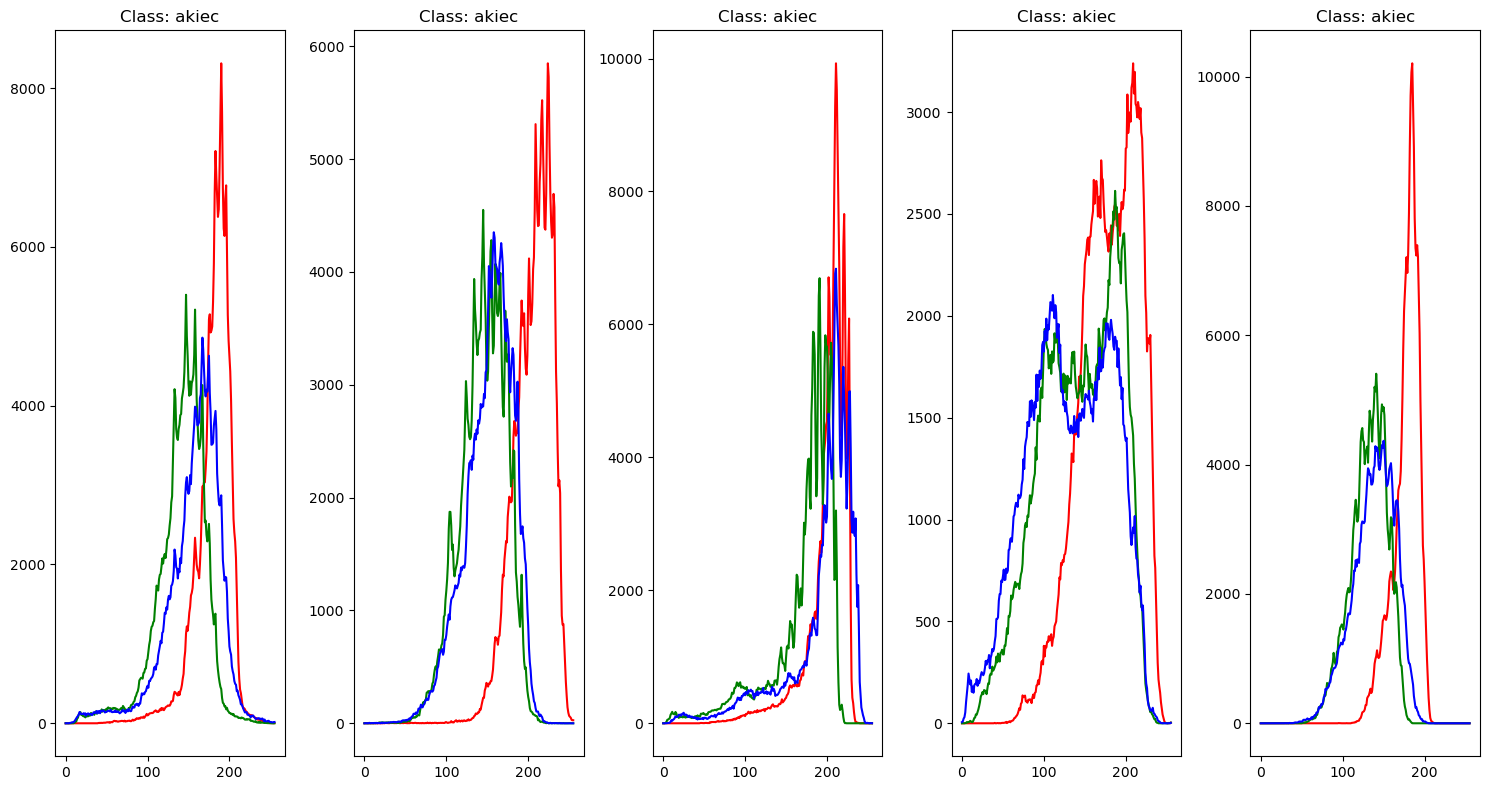

In [34]:
class_labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for class_label in class_labels:
    print(f"\n--- Showcasing examples for class: {class_label} ---\n")
    images, labels = randImg(df=metadata, label=class_label, seed=42, sample_size=5)

    # For displaying images
    pltImg(images, labels, 1, 5)
    # pltImgEq(images, labels, 1, 5)
    # For displaying histograms
    pltHist(images, labels, 1, 5)


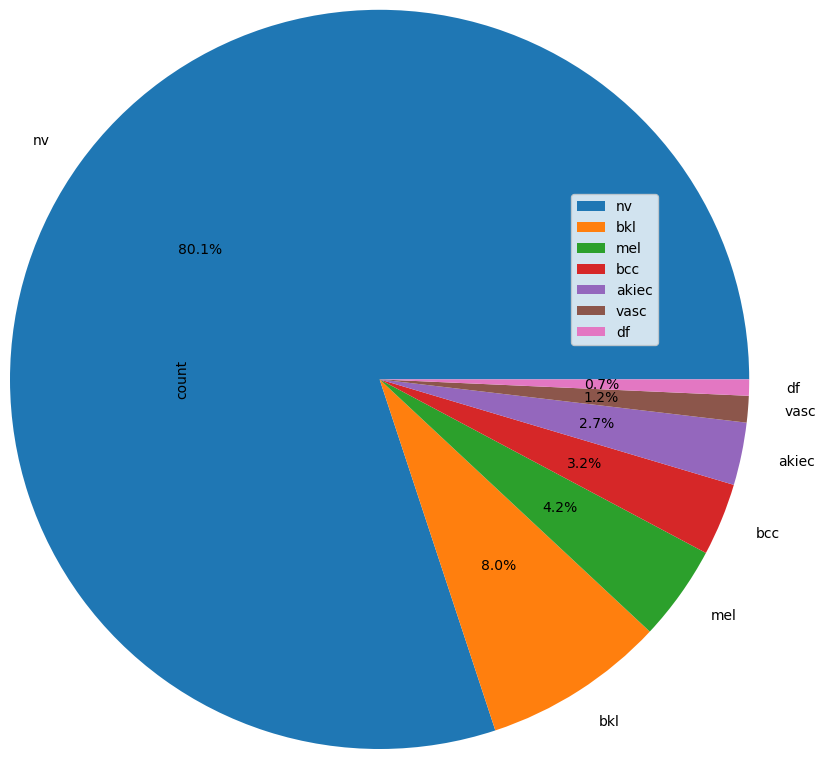

In [35]:
count = metadata['dx'].value_counts()
ax = count.plot(kind="pie", autopct='%1.1f%%', legend=True,radius=2.5)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [36]:
count

dx
nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: count, dtype: int64


LABELS :

1. Melanocytic nevi (nv) -

Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.

[4415 images]

2. Melanoma (mel) -

Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.

[230 images]

3. Benign keratosis-like lesions (bkl) -

"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.

[440 images]

4. Basal cell carcinoma (bcc) -

Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.

[175 images]

5. Actinic keratoses (akiec) -

Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.

[151 images]

6. Vascular lesions (vasc) -

Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.

[64 images]

7. Dermatofibrom (df) -

Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].

[39 images]

[Total images = 5514]


# Data Augmentation

In [37]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [38]:
count = metadata['dx'].value_counts().sort_index()
count

dx
akiec     151
bcc       175
bkl       440
df         39
mel       230
nv       4415
vasc       64
Name: count, dtype: int64

<Axes: ylabel='count'>

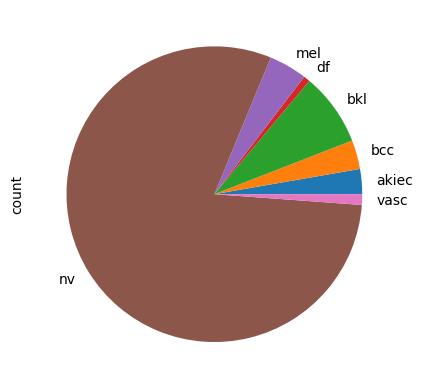

In [39]:
count.plot(kind='pie')

We can observe the huge imbalance between classes.

In [40]:
def data_aug(df, col_name, val_name, class_max):
  ''' This function balances the classes by 2 using the overrepresentation of the minor class'''
  given_cols = df[df[col_name].isin([val_name, class_max])]
  class_counts = df[col_name].value_counts()
  class_count_max = class_counts[class_max]
  class_count_val = class_counts[val_name]
  max_class = given_cols[given_cols[col_name]==class_max]
  val_class = given_cols[given_cols[col_name]==val_name]
  val_class_over = val_class.sample(class_count_max,replace= True)
  df = df[df[col_name] != val_name]
  df = pd.concat([df,val_class_over],axis=0)
  return df

In [41]:
class_max = count.idxmax()

for val_name in metadata.dx.unique():
  if val_name != class_max:
    metadata = data_aug(metadata,'dx',val_name,class_max)

metadata.shape

(30905, 9)

<Axes: ylabel='count'>

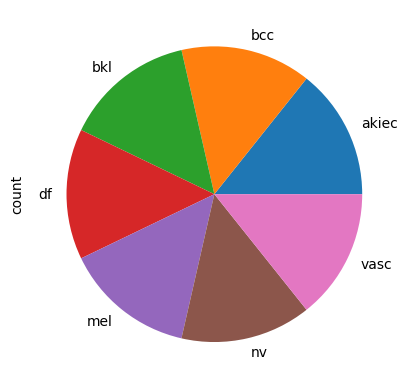

In [42]:
count = metadata['dx'].value_counts().sort_index()
count.plot(kind='pie')

# Data export

For metadata['dx']:

   *'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6*

In [43]:
enum_labels = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

metadata['dx_cat'] = metadata['dx'].replace(enum_labels)



In [44]:
metadata.dx_cat.unique()

array([1, 0, 2, 3, 4, 5, 6], dtype=int64)

In [46]:
metadata.to_csv('pfe/data_enum.csv', index=False)